# Entrenamiento de Letras Dinámicas con Features Pre-extraídos
*Generado: 2025-06-30 20:21*

Este cuaderno carga secuencias de **landmarks ya guardadas** en archivos `.npy` (`features/dynamics/<letra>/<clip>.npy`) y entrena un **Bi-LSTM** para clasificar las letras dinámicas (J, Z, CH, etc.) del alfabeto LSM.

## 1  Dependencias

In [ ]:
!pip install tensorflow scikit-learn pandas numpy matplotlib seaborn tqdm -q

## 2  Imports y rutas

In [16]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, pathlib, pickle, joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

ROOT = Path('..').resolve()
CSV_PATH = ROOT / 'data' / 'dynamics_sequences.csv'
MODEL_DIR = ROOT / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print('CSV:', CSV_PATH)

CSV: C:\Users\Jamin\Documents\Proyectos\sign-language-ml\data\dynamics_sequences.csv


## 3  Carga y exploración del CSV

                                 feature_path label
0  data/dynamics/features/J/S1-J-perfil-1.npy     J
1  data/dynamics/features/J/S1-J-perfil-2.npy     J
2  data/dynamics/features/J/S1-J-perfil-3.npy     J
3  data/dynamics/features/J/S1-J-perfil-4.npy     J
4  data/dynamics/features/J/S1-J-perfil-5.npy     J


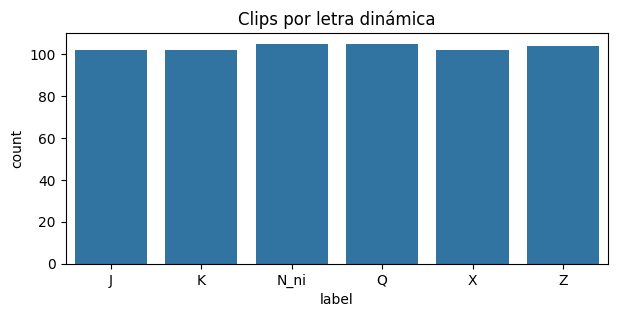

In [17]:
df = pd.read_csv(CSV_PATH)
print(df.head())
plt.figure(figsize=(7,3))
sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
plt.title('Clips por letra dinámica')
plt.show()

## 4  Carga de features `.npy`

In [18]:
X_list, y_list = [], []
for fp, lab in zip(df['feature_path'], df['label']):
    arr = np.load(ROOT / fp)
    X_list.append(arr)
    y_list.append(lab)

X = np.stack(X_list)    # (N, T, 63)
y = np.array(y_list)
SEQ_LEN = X.shape[1]
print('X shape', X.shape)

X shape (620, 30, 63)


## 5  Codificación de etiquetas

In [20]:
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
print('Clases:', list(le.classes_))

Clases: ['J', 'K', 'N_ni', 'Q', 'X', 'Z']


## 6  División Train/Test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_int, test_size=0.2, stratify=y_int, random_state=42)
print(X_train.shape, X_test.shape)

(496, 30, 63) (124, 30, 63)


## 7  Normalizar y guardar estadísticas

In [23]:
X_mean = X_train.mean(axis=(0,1))
X_std = X_train.std(axis=(0,1)) + 1e-8
X_train = (X_train - X_mean) / X_std
X_test  = (X_test - X_mean) / X_std
np.save(MODEL_DIR / "X_mean.npy", X_mean)
np.save(MODEL_DIR / "X_std.npy", X_std)

## 8  Pesos por clase

In [24]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}

## 7  Modelo Bi-LSTM

In [25]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN, 63)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,142 (418.52 KB)

 Trainable params: 107,142 (418.52 KB)

 Non-trainable params: 0 (0.00 B)

### 7.1  Entrenamiento

In [26]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=callbacks,
                    class_weight=class_weights, verbose=2)

Epoch 1/50
13/13 - 4s - 319ms/step - accuracy: 0.6263 - loss: 1.3122 - val_accuracy: 0.7200 - val_loss: 0.8514
Epoch 2/50
13/13 - 0s - 18ms/step - accuracy: 0.8106 - loss: 0.6951 - val_accuracy: 0.7700 - val_loss: 0.5436
Epoch 3/50
13/13 - 0s - 17ms/step - accuracy: 0.8889 - loss: 0.4462 - val_accuracy: 0.8500 - val_loss: 0.4127
Epoch 4/50
13/13 - 0s - 17ms/step - accuracy: 0.9343 - loss: 0.2846 - val_accuracy: 0.8600 - val_loss: 0.3141
Epoch 5/50
13/13 - 0s - 17ms/step - accuracy: 0.9343 - loss: 0.2064 - val_accuracy: 0.8800 - val_loss: 0.2552
Epoch 6/50
13/13 - 0s - 18ms/step - accuracy: 0.9596 - loss: 0.1457 - val_accuracy: 0.8900 - val_loss: 0.2410
Epoch 7/50
13/13 - 0s - 17ms/step - accuracy: 0.9646 - loss: 0.1204 - val_accuracy: 0.9100 - val_loss: 0.2229
Epoch 8/50
13/13 - 0s - 17ms/step - accuracy: 0.9621 - loss: 0.1081 - val_accuracy: 0.8700 - val_loss: 0.2417
Epoch 9/50
13/13 - 0s - 17ms/step - accuracy: 0.9722 - loss: 0.0875 - val_accuracy: 0.8900 - val_loss: 0.2701
Epoch 10/

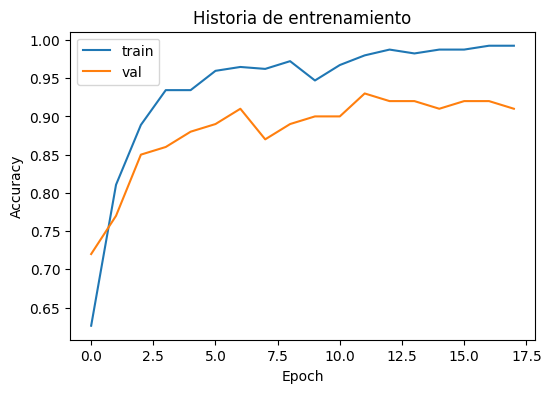

In [27]:
pd.DataFrame(history.history).to_csv(MODEL_DIR / "training_log.csv", index=False)
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Historia de entrenamiento')
plt.savefig(MODEL_DIR / "training_plot.png")
plt.show()

### 7.2  Evaluación en test

Test accuracy: 0.935
              precision    recall  f1-score   support

           J       1.00      1.00      1.00        20
           K       0.95      0.90      0.92        20
        N_ni       0.95      1.00      0.98        21
           Q       1.00      0.76      0.86        21
           X       0.80      0.95      0.87        21
           Z       0.95      1.00      0.98        21

    accuracy                           0.94       124
   macro avg       0.94      0.94      0.94       124
weighted avg       0.94      0.94      0.93       124



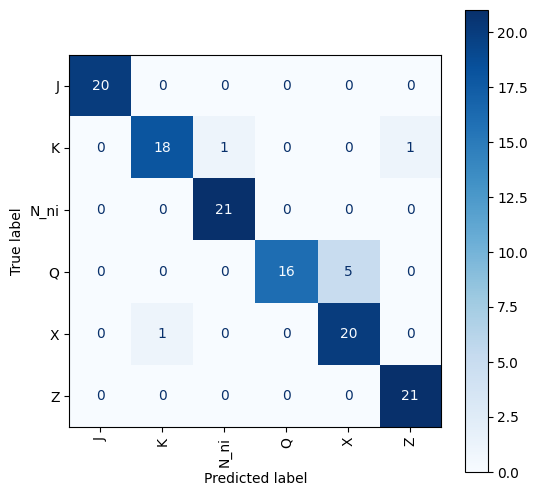

In [28]:
# ─── Evaluación ──────────────────────
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.3f}')
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ─── Matriz de confusión ─────────────
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.savefig(MODEL_DIR / "confusion_matrix.png")
plt.show()

## 8  Guardar modelo y codificador

In [29]:
model.save(MODEL_DIR / 'dynamic_letters_lstm.h5')
with open(MODEL_DIR / 'dynamic_letters_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
with open(MODEL_DIR / 'dynamic_letters_label_map.txt', 'w') as f:
    for i, label in enumerate(le.classes_):
        f.write(f'{i}: {label}\n')

print('✅ Todo guardado en', MODEL_DIR)

✅ Todo guardado en C:\Users\Jamin\Documents\Proyectos\sign-language-ml\models


## 9  Próximos pasos
* Experimentar con GRU o Transformer Encoder si tienes más datos.
* Fusionar estas predicciones con las del modelo estático (late fusion).
* Exportar a TensorFlow Lite para despliegue en móviles o Raspberry Pi.